In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.utils import class_weight
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.4),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomCrop(224, 224),
    layers.Rescaling(1./255)
])

In [4]:
data_dir = "/content/drive/MyDrive/MCVSLD/Multi-Class Viral Skin Lesion Dataset (MCVSLD)/Skin Lesion Dataset/Skin Lesion Dataset"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/train", image_size=(224, 224), batch_size=64, label_mode="int"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + "/val", image_size=(224, 224), batch_size=64, label_mode="int"
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 9060 files belonging to 6 classes.
Found 1131 files belonging to 6 classes.


In [5]:
y_train = []
for images, labels in train_ds:
    y_train.extend(labels.numpy())
y_train = np.array(y_train)
cw = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : cw[i] for i in range(len(cw))}
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.6777777777777778), 1: np.float64(1.9065656565656566), 2: np.float64(0.7815734989648033), 3: np.float64(1.1038011695906433), 4: np.float64(2.287878787878788), 5: np.float64(0.443075117370892)}


In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), include_top=False, weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(6, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/80
142/142 ━━━━━━━━━━━━━━━━━━━━ 135s 839ms/step - accuracy: 0.4674 - loss: 1.2862 - val_accuracy: 0.4527 - val_loss: 2.9391 - learning_rate: 1.0000e-04
Epoch 2/80
142/142 ━━━━━━━━━━━━━━━━━━━━ 23s 165ms/step - accuracy: 0.7465 - loss: 0.5601 - val_accuracy: 0.3996 - val_loss: 3.8099 - learning_rate: 1.0000e-04
Epoch 3/80
142/142 ━━━━━━━━━━━━━━━━━━━━ 24s 166ms/step - accuracy: 0.8021 - loss: 0.4234 - val_accuracy: 0.4226 - val_loss: 4.3063 - learning_rate: 1.0000e-04
Epoch 4/80
142/142 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - accuracy: 0.8448 - loss: 0.3268 - val_accuracy: 0.2997 - val_loss: 4.7545 - learning_rate: 1.0000e-04
Epoch 5/80
142/142 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - accuracy: 0.8727 - loss: 0.2747 - val_accuracy: 0.4695 - val_loss: 2.8107 - learning_rate: 1.0000e-04
Epoch 6/80
142/142 ━━━━━━━━━━━━━━━━━━━━ 23s 164ms/step - accuracy: 0.8941 - loss: 0.2197 - val_accuracy: 0.4456 - val_loss: 3.2280 - learning_rate: 1.0000e-04
Epoch 7/80
142/142 ━━━━━━━━━━━━━━━━━━━━ 23s 1

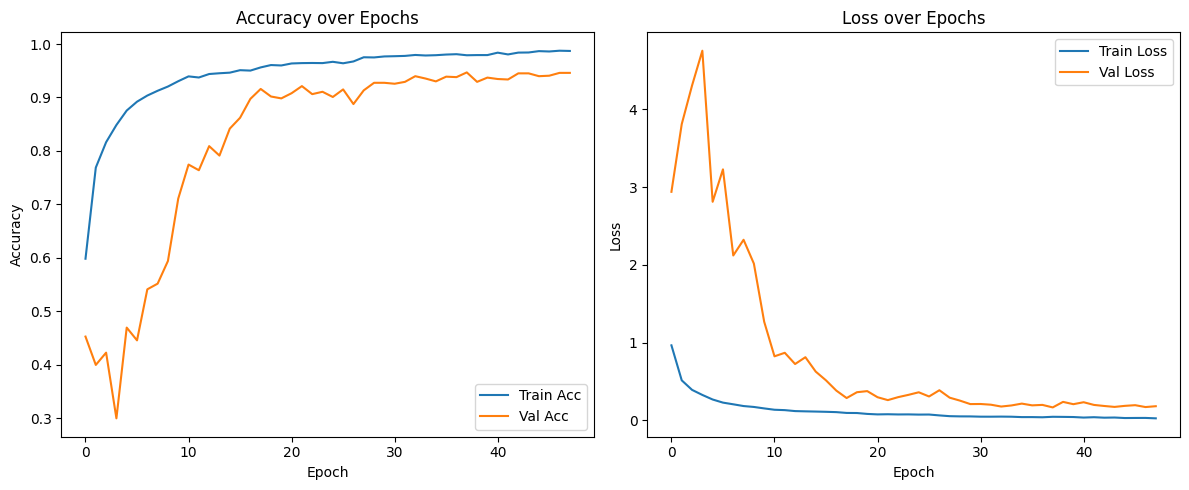

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
train_raw = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir + '/train',
    image_size=(224, 224),
    batch_size=64,
    label_mode="int"
)

class_names = train_raw.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_raw.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

Found 9060 files belonging to 6 classes.
['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


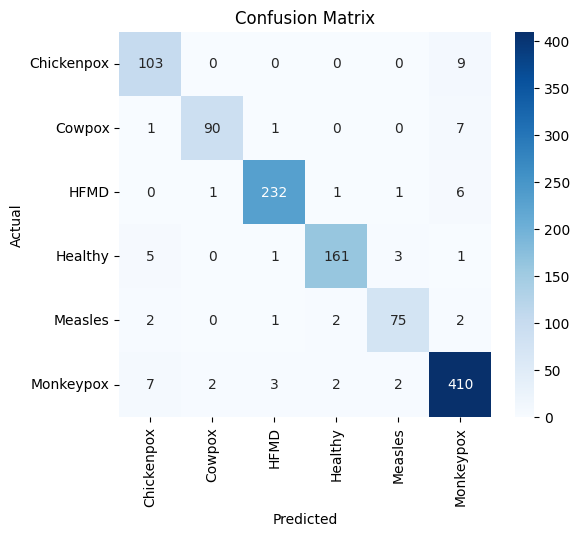

Classification Report:

              precision    recall  f1-score   support

  Chickenpox       0.87      0.92      0.90       112
      Cowpox       0.97      0.91      0.94        99
        HFMD       0.97      0.96      0.97       241
     Healthy       0.97      0.94      0.96       171
     Measles       0.93      0.91      0.92        82
   Monkeypox       0.94      0.96      0.95       426

    accuracy                           0.95      1131
   macro avg       0.94      0.93      0.94      1131
weighted avg       0.95      0.95      0.95      1131



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds_class = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds_class)

labels_name = ['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_name, yticklabels=labels_name, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels_name))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step


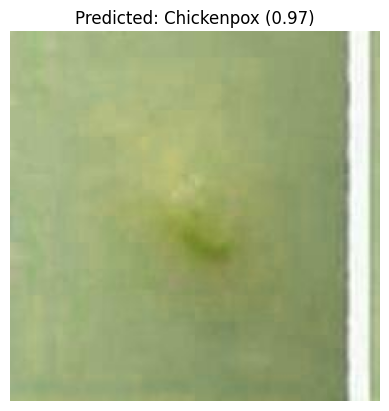

('Chickenpox', np.float32(0.9736695))

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def predict_image(img_path, model, class_names=['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']):
    img = tf.keras.utils.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)[0][0]
    label_index = int(prediction > 0.5)
    confidence = prediction if label_index == 1 else 1 - prediction

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_names[label_index]} ({confidence:.2f})")
    plt.show()

    return class_names[label_index], confidence

img_path = "/content/drive/MyDrive/MCVSLD/2Class_Chickenpox_Healthy/test/Chickenpox/CHP_04_01_6.jpg"
predict_image(img_path, model)

In [15]:
model.save("medical_model.keras")



In [20]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np

model = load_model("medical_model.keras")
CLASS_NAMES =['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox']
def predict_image(path):
    image = Image.open(path).resize((224, 224)).convert("RGB")
    img_array = np.expand_dims(np.array(image) / 255.0, axis=0)
    predictions = model.predict(img_array)[0]
    return dict(zip(CLASS_NAMES, [float(p) for p in predictions]))


In [24]:
result = predict_image("/content/drive/MyDrive/MCVSLD/Multi-Class Viral Skin Lesion Dataset (MCVSLD)/Skin Lesion Dataset/Skin Lesion Dataset/test/Cowpox/CWP_03_01_2.jpg")
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
{'Chickenpox': 0.02670362778007984, 'Cowpox': 0.9294711351394653, 'HFMD': 0.0008142489823512733, 'Healthy': 0.02054210565984249, 'Measles': 0.005388726480305195, 'Monkeypox': 0.01708020269870758}


In [26]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('medical_model.keras', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpai0ullif'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138650950205712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138650950207056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138650950207440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138650950207248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138650950205904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138650950208592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138650950208976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138650950209360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138650950209168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138650950206480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1386509502105